In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tcod

%matplotlib inline

In [0]:
%load_ext autoreload
%autoreload 2

# Pyglet

In [41]:
import pyglet, time
from pyglet.gl import *
glEnable(GL_BLEND)
glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)

#%cd /Users/millejoh/Documents/GitHub/Islands/

ImportError: No module named 'pyglet'

# Pyglet/IPython Integration

Per the 3.x
[documentation](http://ipython.org/ipython-doc/stable/config/eventloops.html)
to integrate an event loop with the kernel (not the terminal) it must occasionally call
[`IPython.kernel.zmq.kernelbase.Kernel.do_one_iteration()`](http://ipython.org/ipython-doc/stable/api/generated/IPython.kernel.zmq.kernelbase.html#IPython.kernel.zmq.kernelbase.Kernel.do_one_iteration).

The decorator `@register_integration(<name>)` will add special semantics to the `%gui <name>` magic.

Wonder if scheduling calls through `pyglet.clock.schedule` will work?

In [3]:
from IPython.kernel.zmq.eventloops import register_integration

def kernel_callback(dt, kernel):
    kernel.do_one_iteration()

@register_integration('pyglet')
def pyglet_event_loop(kernel):
    pyglet.clock.schedule_interval(kernel_callback, 0.1, kernel)
    pyglet.app.run()

c:\users\millejoh\miniconda3\envs\py35\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
%gui pyglet

Yes, yes it does. One thing that doesn't seem to work so well, however, is
stopping and restarting the pyglet event loop. As in, doesn't work at all.
Another issue seems to be CPU resource issue. The callback interval could
probably be tweaked to trade off response time vs. cpu usage.

Okay, now can we tweak event handlers while the app is live?

# Graphics

With 2D rougelike text graphics we split the screen into cells, each
cell has a background color, a foreground color, and a glyph. This
does not give a lot of options for displaying information about the world.

Alpha doesn't seem to be working with glyphs, so for the moment it is one of either
glyph+foregroud color or background cell color.

A `GlyphSet` 


In [5]:
%run pyglet_grid.py

In [6]:
world_width = 80
world_height = 50 # n x n grid
imsize = 12 # Font is 12x12

worldpx_w, worldpx_h = world_width * imsize, world_height * imsize

# terrain = np.zeros((world_height, world_width))
#im_set = pyglet.image.load('12x12.png')
#im_set_seq  = pyglet.image.ImageGrid(im_set, 48, 16)
# im_set_tex_seq = pyglet.image.TextureGrid(im_set_seq)

gs = GlyphSet('12x12.png', 48, 16)

In [7]:
grid = Grid(80,60)
grid.init_window()
grid.init_grid()
grid.init_vertex_list()

In [21]:
grid[0,0] = Cell(gs['@'], Color('grey'), Color('grey'))
grid[0,1] = Cell(gs[' '], Color('white'), Color('blue'))
grid[1,0] = Cell(gs[' '], Color('white'), Color('blue'))
glyph = gs['@']
blue = Color('blue')
water = pyglet.image.SolidColorImagePattern(color=(0,0,255,255))
water_square = pyglet.sprite.Sprite(water.create_image(10, 10))

In [18]:
blue.get_rgb()

(0.0, 0.0, 1.0)

In [22]:
@grid.window.event
def on_draw():
    #water_square.draw()
    grid.window.clear()
    grid.draw()
    water_square.draw()
    glyph.draw()

In [23]:
glyph.scale = 10/12
glyph.opacity = 255

In [24]:
water_square.x = 50
water_square.y = 50

In [26]:
glyph.x = 20
glyph.y = 20

In [9]:
batch = pyglet.graphics.Batch()

In [8]:
canvas = pyglet.window.Window(worldpx_w, worldpx_h)

Draw a glyph.

In [38]:
glyph0 = gs[0]
glyph1 = gs[2, 1]
glyph2 = gs['@']
glyph0.x, glyph0.y = canvas.width//2, canvas.height//2
glyph2.x, glyph2.y = 40, 40
glyph0.batch = batch
glyph1.batch = batch
glyph2.batch = batch

In [11]:
#water = pyglet.image.SolidColorImagePattern(color_rgba(keyrgb_color_int[0]))
white = pyglet.image.SolidColorImagePattern((0, 0, 50, 255))
#water_square = pyglet.sprite.Sprite(water.create_image(imsize, imsize))
big_white = pyglet.sprite.Sprite(white.create_image(12, 12))

In [12]:
glyph1.x, glyph1.y = 10, 10
@canvas.event
def on_draw():
    canvas.clear()
    #water_square.draw()
    big_white.draw()
    batch.draw()

In [19]:
big_white.x, big_white.y = 10, 10

In [18]:
glyph0.color = (0,50,80)
glyph2.color = (255, 255, 255)

In [21]:
glyph1.opacity = 255

In [22]:
def update(dt):
    # Move 10 pixels per second
    if glyph1.x > canvas.width:
        glyph1.x = 0
    else:
        glyph1.x += dt * 10

# Call update 60 times a second
pyglet.clock.schedule_interval(update, 1/60.)

In [26]:
glyph0.batch = batch

In [8]:
Color('red')

<Color red>

# Heightmaps

In [3]:
import Heightmap as hm
import numpy as np

In [0]:
map = np.ones((50, 50))

In [5]:
hm.add_hill(map, 10, 10, 5, 2)

In [0]:
hm.dig_hill(map, 30, 30, 5, 2)

In [9]:
fig = plt.imshow(map, origin='lower')
plt.colorbar()

C:\Users\millejoh\Miniconda3\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


# World Generation

In [9]:
tcod.noise_get_fbm

<function tcod.libtcodpy_x64.noise_get_fbm>

In [0]:
from worldgen import WorldGenerator

In [4]:
wg = WorldGenerator(400, 400)
print(wg)

## World Generation Protocol

Steps to build the world:

1. Build base heightmap.
2. Calculate precipitation.
3. Erode.
4. Smooth.
5. Generate rivers
6. Smooth precipitation.
7. Computer temperatures and biomes.

In [12]:
wg.build_base_map()

In [13]:
wg.compute_precipitation()

In [20]:
wg.erode_map()

TypeError: descriptor 'flow_dir' for 'MapData' objects doesn't apply to 'MapData' object

In [37]:
wg.smooth_map()

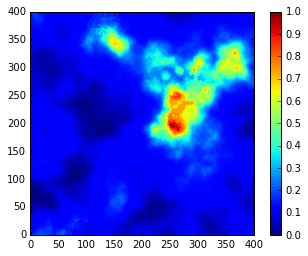

In [19]:
plt.imshow(wg._hm, origin='lower', vmax=1.0)
plt.colorbar()

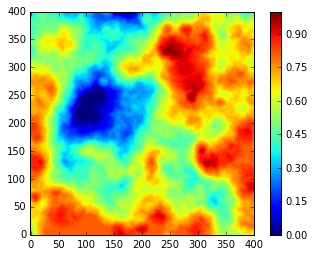

In [32]:
plt.imshow(wg._hm2, origin='lower')
plt.colorbar()

In [45]:
np.amin(wg._hm)

-4.5020419422223686e-17

# Performance Testing

World generation involves lots of looping over numpy arrays, so there
should be plenty of opportunities to use numba/cython (others?) to
optimize. The good and bad of coding on Surface 3 is that performance
debits are accentuated with the Atom processor. It has multi-cores,
though, which numba should be able to take advantage of, right?

First see if numba is actually doing anything on this architecture
using the example from the front page of numbas
[documentation](http://numba.pydata.org/).

In [24]:
from numba import jit
from numpy import arange

In [25]:
# Without numba
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(9).reshape(3,3)

print(a)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [28]:
%timeit sum2d(a)

10000 loops, best of 3: 36.8 µs per loop


In [27]:
@jit
def sum2d_numba(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [35]:
%timeit sum2d_numba(a)

The slowest run took 16.01 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 759 ns per loop


Looks like optimizations are happening - the jit code executes, at best, at 741ns while the not jit code executes 37.2us per loop, not quite two orders of magnitude faster.

Now to find out where the bottleneck is in the world genertion code.


### World Generation Breakdown

In [0]:
test_world = WorldGenerator(10,10)

In [10]:
%timeit wg.build_base_map(6)

1 loops, best of 3: 23.1 s per loop
